## 1. Motivation

Many kids grew up with disney films and shows and often inspired by disney. Today, we will be looking at disney characters and find out more about their personalities types. <br> <br> 
The dataset used is extracted from the [Disney wikia](http://disney.wikia.com/wiki/The_Disney_Wiki). We will be extracting out all the disney characters with articles available on the disney wikia page and their corresponding "personality" section of their individual article. <br><br>
A network will be formed from mapping out personalities traits and characters as nodes. If a character possesses a personality trait, a link will be formed between the two. Analysis of the network will then be carried out. <br><br>
The goal of this is simple, is to allow disney fans to understand their beloved characters more and also for characters' creator to pickup some insights about disney characters' personalities.  <br><br>

## 2. Basic stats. Let's understand the dataset better

### Preprocessing

To get started, we need to first extract all the characters names and their wikia link.

In [1]:
import requests
query = "http://disney.wikia.com/api/v1/Articles/List?expand=1&category=Disney_characters&limit=10000"
char = requests.get(query)

In [2]:
characters = [c for c in char.json()['items'] if 'List of' not in c['title'] and 'Characters' not in c['title'] and 'characters' not in c['title']]
characters = [c for c in characters if 'type' in c.keys()]
characters = [c for c in characters if c['type'] == 'article']

An example of an element in characters:

In [3]:
characters[0]

{u'abstract': u'9-Eye was the deuteragonist of The Timekeeper. 9-Eye was the assistant to The Timekeeper, and...',
 u'comments': 0,
 u'id': 474577,
 u'ns': 0,
 u'original_dimensions': {u'height': 350, u'width': 359},
 u'revision': {u'id': 2199635,
  u'timestamp': u'1461025257',
  u'user': u'Lightening McQueen',
  u'user_id': 5194340},
 u'thumbnail': u'http://vignette2.wikia.nocookie.net/disney/images/7/77/9-eye.jpg/revision/latest/window-crop/width/200/x-offset/6/y-offset/0/window-width/351/window-height/350?cb=20141217213030',
 u'title': u'9-Eye',
 u'type': u'article',
 u'url': u'/wiki/9-Eye'}

Once we have the list of all the disney characters, we will then proceed to extracting their article. To do so, we will be using ['url'][6:] to request for the json version of the full article.

In [ ]:
import urllib2
import json

characters_details = []
articles = []

for character in characters[:1000]:
    baseurl = "http://disney.wikia.com/api.php?" 
    action = "action=query"
    title = "titles=%s" % character['url'][6:]
    content = "prop=revisions&rvprop=content"
    dataformat = "format=json"
    query = "%s%s&%s&%s&%s" % (baseurl, action, title, content, dataformat)
    wikiresponse = urllib2.urlopen(query)
    wikisource = wikiresponse.read()
    wikijson = json.loads(wikisource)
    stuff = wikijson[u'query'][u'pages'][str(character['id'])][u'revisions'][0][u'*']
    if '|personality' in stuff:
        characters_details.append(character)
        articles.append(stuff)

In [ ]:
# add articles into the character dictionary
for i in range(len(characters_list)):
    characters_details[i]['article'] = articles[i]

We will writing the data to a json file. This json file is 28.4MB.

In [5]:
import json
# write to json file
with open('characters_list', 'w') as f:
    json.dump(characters_list, f)

In [2]:
# read json file
with open('characters_list') as f:
    characters_details = json.load(f)

Now the dataset will contains the below elements for each character. The two that we are particularly interested in is 'title' and the personalites that will be extracted from 'article'.

In [6]:
characters_details[0].keys()

[u'title',
 u'url',
 u'type',
 u'abstract',
 u'comments',
 u'id',
 u'article',
 u'ns',
 u'original_dimensions',
 u'thumbnail',
 u'revision']

In [3]:
characters = [char_d['title'] for char_d in characters_details]

In [4]:
articles = [char_d['article'] for char_d in characters_details]

Before we can start mapping out the network, we need to extract out the personalites in 'article'. We will be using .index to find the position of the personalites in the text and then splitting out the elements into a list. After that, we need to filter out characters that have personalites in the LabMT wordlist. This ensures that when we do sentiment analysis later on, the results will actually be useful.

In [6]:
# Load words with sentiment
labMT = {}
f = open('./Data_Set_S1.txt', 'r')
lines = f.readlines()[4:]
for ele in lines:
    word = ele.split('\t')
    labMT[word[0]] = float(word[2])
labMTwords = labMT.keys()

In [7]:
per_types = set()
personality_dict = {}
for i in range(len(articles)):
    pos = articles[i].index("personality")+14
    if articles[i].find("|", pos) != -1:
        end = articles[i].index("|", pos)-1
    else:
        end = articles[i].index("}", pos)
    pers_list = articles[i][pos:end].lower().split(", ")
    pers_list = [x for x in pers_list if x in labMTwords] # only personality available in labMT words
    personality_dict[characters[i]] = pers_list
    per_types.update(pers_list)

In [8]:
red_pers_dict =  {k:v for k, v in personality_dict.items() if v != []} # filter away those without personality

In [9]:
print "%d out of %d characters have personalites in labMT list"%(len(red_pers_dict), len(characters))

3248 out of 4095 characters have personalites in labMT list


In [10]:
overlap = list(per_types & set(labMTwords))
print "The network that will be created will contain 3248 characters and %d personalites"%(len(overlap))

The network that will be created will contain 3248 characters and 449 personalites


### Building the network

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G=nx.DiGraph(red_pers_dict)

Red nodes indicates personalites while blue nodes indicates characters.

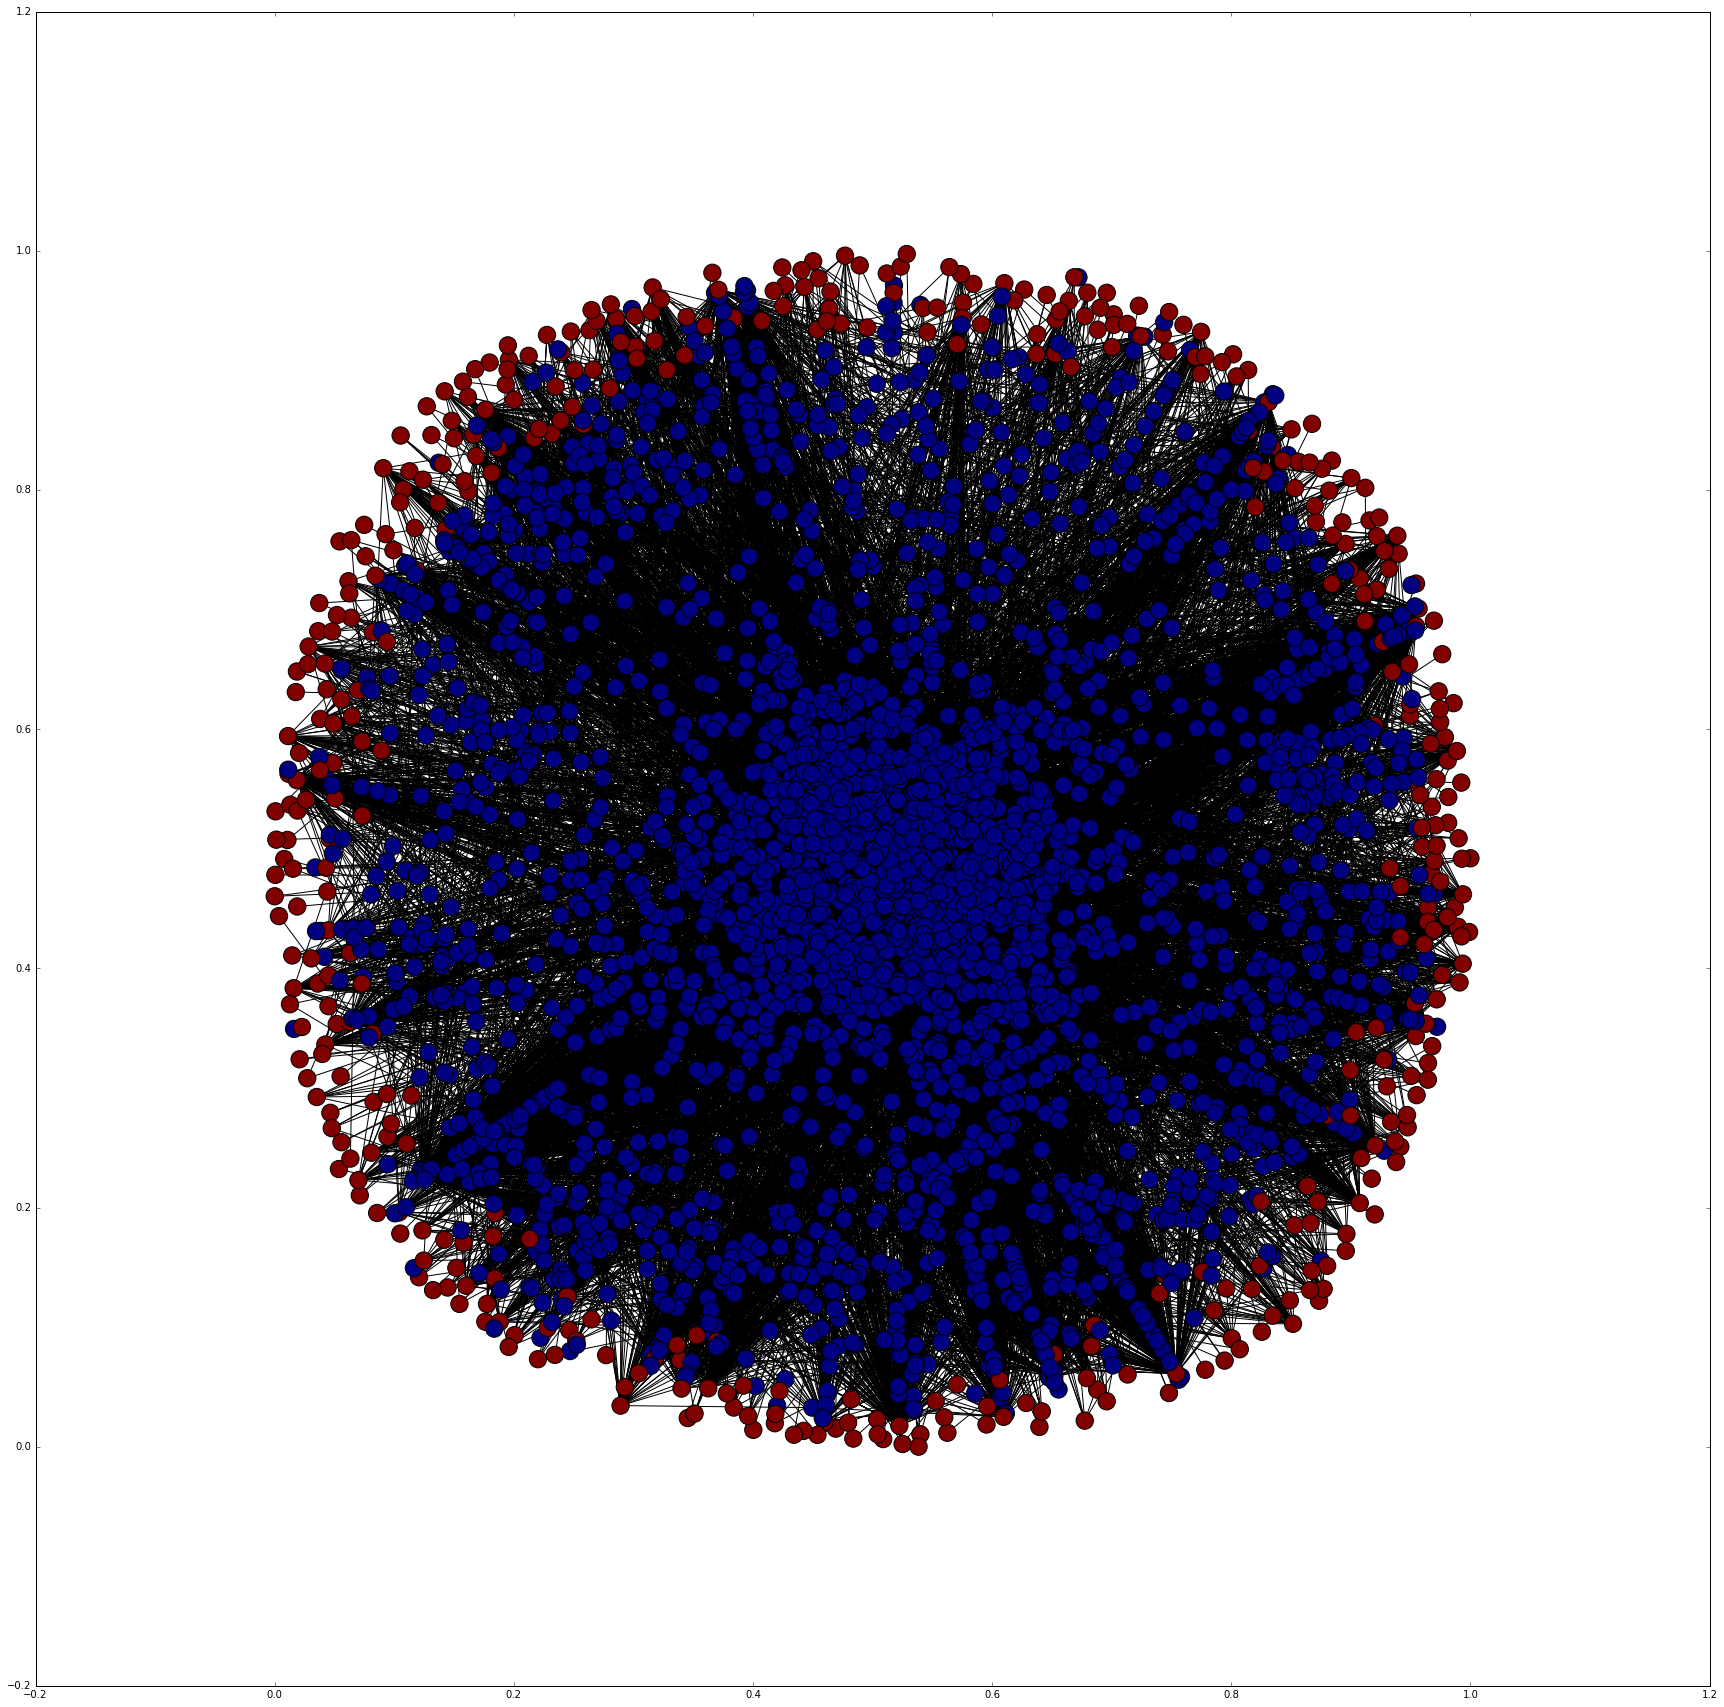

In [19]:
plt.figure(2,figsize=(30,30)) 

pos = nx.spring_layout(G)

# red is personalities while blue is characters
values = [0.25 if node in red_pers_dict.keys() else 1 for node in G.nodes()] 

# draw nodes and edges separately
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color = values)
nx.draw_networkx_edges(G, pos, arrows=False)

### Basic Stats

In [12]:
import numpy as np
print "There are a total of %d nodes and %d links." % (G.number_of_nodes(), G.size())
avg = G.size()/float(G.number_of_nodes())
print "Average degree is %.2f." % avg
degree_sequence= sorted(nx.degree(G).values(),reverse=True) 
print "Median degree is %d." % np.median(degree_sequence)

There are a total of 3697 nodes and 10352 links.
Average degree is 2.80.
Median degree is 3.


In [13]:
degree_sequence=nx.degree(G).values() # get all the degree of the nodes
print "Maximum degree: %d" % max(degree_sequence)
print "Minimum degree: %d" % min(degree_sequence)

Maximum degree: 817
Minimum degree: 1


## 3. Tools, theory and analysis. Describe the process of theory to insight

Techniques to deal with the text is discussed in the section above during preprocessing. .index to find the position of the personalites in the text and then splitting out the elements into a list. UTF-8 is used to print characters' names when there is an UnicodeEncodeError: 'ascii' codec can't encode character.

### Highest in-degrees centrality

In [15]:
idc = nx.in_degree_centrality(G)
sorted_idc = sorted(idc.items(), key=lambda x: x[1], reverse=True)
sorted_idc[:10]

[(u'kind', 0.22104978354978355),
 (u'caring', 0.13555194805194806),
 (u'friendly', 0.12581168831168832),
 (u'loyal', 0.09172077922077922),
 (u'brave', 0.08522727272727272),
 (u'funny', 0.0836038961038961),
 (u'sweet', 0.07954545454545454),
 (u'mean', 0.07278138528138528),
 (u'helpful', 0.05925324675324675),
 (u'intelligent', 0.058982683982683984)]

In [17]:
# different method to achieve most popular personality.
from collections import Counter
in_deg = Counter(G.in_degree())
print "Top 10 most popular personality (by in-degree) are \n"
for name in in_deg.most_common()[:10]:
    print name[0]

Top 10 most popular personality (by in-degree) are 

kind
caring
friendly
loyal
brave
funny
sweet
mean
helpful
intelligent


Only one out of the top 10 personalities have negative meaning. This is very logical as disney films are usually made up good characters mostly, with only a few villians in each movie or show. 

### Degree Assortativity Coefficient

In [46]:
nx.degree_assortativity_coefficient(G)

-0.040968608930517528

This negative coefficient is logical as it all depends on how many personalities traits were listed for each character on their wikia page. For example, a character can have little personality listed but is connected to a personality traits linked to many characters. 

### Forming communities

Now we will create a undirected graph so we can make use of the community function.

In [23]:
NG=nx.Graph(red_pers_dict)

In [28]:
import community
#first compute the best partition
partition = community.best_partition(NG)
community.modularity(partition, NG)

0.4396187311354387

In [29]:
max(partition.values())

34

In [30]:
comm = [[] for i in range(35)]
for k,v in partition.items():
    comm[v].append(k)

In [31]:
sizes = [len(com) for com in comm]
print sizes

[101, 414, 49, 95, 335, 757, 107, 237, 337, 98, 253, 289, 94, 343, 105, 36, 2, 2, 2, 3, 3, 5, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2]


Many of the communities only contain 2 or very little nodes. These communites will be ignored in our analysis of communities as they contains characters that have very unique personality traits.

In [32]:
real_comm = [com for com in comm if len(com) >10]

After analysing the 16 main communities created, some insights were found. <br>
Initially, it was simply thought that they will probably distributed the characters into just heroes and villians with their corresponding good and bad personalites. <br>
However, disney characters not just heroes and villians. Most characters are there for plot development and thus do not belong to that two category. Furthermore, even within heroes or villians, there are a varied list of personality traits one can have.
<br>
One main insight found is that communities formed are definitely not by the show. Characters from the same show will usually be distributed into different communites as they have distinct personalities. This makes sense as a show with characters with similar personalites will not be exciting.

An example is illustrated with the main characters of the movie - Wreck-It Ralph. The below code will find out which community does each character belong to.

In [63]:
WIR = ["Vanellope von Schweetz","King Candy","Wreck-It Ralph (character)","Sergeant Calhoun","Fix-It Felix, Jr."]
for character in WIR:
    for i in range(len(real_comm)):
        if character in real_comm[i]:
            print "%s is in community %d."%(character,i) 
            break

Vanellope von Schweetz is in community 13.
King Candy is in community 5.
Wreck-It Ralph (character) is in community 6.
Sergeant Calhoun is in community 8.
Fix-It Felix, Jr. is in community 1.


It is found that all the characters are grouped into different communities due to their very different characteristics.

### Sentiment Analysis on Popular Characters' Personalities

To get the list of popular characters, we will be using disney wikia api to extract top viewed disney characters pages.

In [34]:
import requests
query = "http://disney.wikia.com/api/v1/Articles/Top?Expand=1&category=Disney_characters&limit=250"
pop = requests.get(query)
pop_char = [p['title'] for p in pop.json()['items'] if p['title'] in red_pers_dict.keys()]
pop_pers = {k:v for k,v in red_pers_dict.items() if k in pop_char}

We will then perform sentiment analysis on their personality stated. If it scored an average sentiment of above 5, it will be listed as good, and below 5 will be listed as bad.

In [36]:
from __future__ import division
good = []
bad = []
for k,v in pop_pers.items():
    sent = 0
    for pers in v:
        sent += labMT[pers]
    sent = sent/len(v) 
    if sent >= 5:
        good.append(k)
    else:
        bad.append(k)

In [78]:
print "%.2f %% characters in the popular list are good!"%(len(good)/len(bad+good)*100)

74.87 % characters in the popular list are good!


People are indeed more attracted to good characters more than the bad. However around 25% of the characters are bad, which means that people are generally still very interested in characters with bad personality as well.

In [37]:
for char in good:
    print char

Ursula
Kopa
Victor, Hugo, and Laverne
Dipper Pines
Doug (Zootopia)
Princess Charlotte
Princess Vivian
Cobra Bubbles
Anna
Yax
Sebastian
Fuli
Evie
Kronk
Layla Williams
Finnick
Blue Fairy
Flash
Bambi's mother
Alistair Krei
Zuzo
Marina Del Rey
Stitch
Alice
Wardrobe
Pocahontas (character)
Kristoff
Mrs. Potts
Lilo Pelekai
Wreck-It Ralph (character)
Jasiri
Sergeant Calhoun
Mateo
Oaken
Kairi
Powerline
Sheriff of Nottingham
Huey, Dewey and Louie
Clawhauser
Belle
Vanellope von Schweetz
Go Go Tomago
Princess Elena
Mickey Mouse
Akela
Jumba Jookiba
Belle's Mother
Taffyta Muttonfudge
Gabe
Fru Fru
Aurora
Moana Waialiki
Wasabi
King Roland II
Mayor Lionheart
Flynn Rider
Pinocchio (character)
Sally
Kida Nedakh
Scrooge McDuck
Chancellor Esteban
Bagheera
Tinker Bell
Koda
Baymax
Mr. Big (Zootopia)
CJ Hook
Flik
Genie
Gramma Tala
Fairy Godmother
Marco Diaz
Captain Amelia
Marshmallow
Star Butterfly
John Smith
Jay (Descendants)
Judy Hopps
Cassim
Chief Bogo
Naomi
The Firebird
Helen Parr
Chip Potts
Faline
Ariel


When looking through the list of "good" characters, it was a surprised that some of the villian characters are listed as good after sentiment analysis. One outstanding and well-known example is Ursula from The Little Mermaid.

In [64]:
red_pers_dict["Ursula"]

[u'ambitious', u'elegant']

Ursula was listed as a good character as most of the negative words in its personality list, such as Power-hungry, manipulative, sinister, vengeful, wrathful, sultry, immoral, sadistic, is not included in the labMT list. As a result, this caused a bad representation of the character. A more comprehensive list of words with sentiments could be used to prevent this problem.

In [38]:
for char in bad:
    print char

Captain Hook
Jordan (Descendants)
Janja
Iago
Queen La
Donald Duck
The Coachman
Queen of Hearts
Judge Doom
Grumpy
Forte
Bill Cipher
Tick-Tock the Crocodile
Claude Frollo
The Evil Queen
Scar
Shuriki
Governor Ratcliffe
Princess Ivy
Shan Yu
Morgana
Big Bad Wolf
Honest John and Gideon
Captain Gantu
Lock, Shock, and Barrel
Mr. Manchas
Gwen Grayson
Mertle Edmonds
Stromboli
The Stabbington Brothers
Drizella Tremaine
Shego
Nuka
Gideon Grey
Duke of Weselton
Mother Gothel
Queen Narissa
Princess Amber
Ratigan
Beast
The Red Queen
Orizaba
Sabor
Jane (Descendants)
Bellwether
Lady Tremaine
Yokai
Prince Alonso


### Is there link between personality types and popularity and likability?

We will be calculating the percentage of popular charcters that contain each of the top 10 personalties.

In [68]:
pers_in_popular = [0 for i in range(10)]
for k,v in pop_pers.items():
    for i in range(10):
        if in_deg.most_common()[i][0] in v:
            pers_in_popular[i] += 1
pers_in_popular = [p/len(pop_pers)*100 for p in pers_in_popular]

In [69]:
pers_in_popular

[23.036649214659686,
 23.036649214659686,
 12.56544502617801,
 11.518324607329843,
 13.089005235602095,
 4.712041884816754,
 9.947643979057592,
 3.664921465968586,
 6.282722513089005,
 21.98952879581152]

Popular characters don't contains much popular personalites. This may be due to people liking more original characters that are refreshing instead of characters with personality very similar to other characters.

## 4. Discussion. Think critically about your creation

A better understanding of disney characters is definitely achieved. Each disney show or movie contains characters of so many different characteristics, which allow the plot to be very dynamic, exciting and interesting. Popular characters have no direct link to any specific personality. This shows that there is no need to include a specific personality to appeal to the audience. <br> As most disney movies are generally quite well received and liked, from this project, new show or movie characters creators can learn about what kind of characteristics to include in their characters. <br><br> A possible improvement to the project could be including movies reviews. With that, we could investigate if personality traits have any link to how well a movie will be received. <br><br> A bigger list of adjectives with sentiment can be used. This will allow a better analysis of all the available characters as no personality traits will be left out. For example, Ursula will not have a positive sentiment if all of her personality traits are considered. This will definitely allow a better text analysis of their character.